# **VERINDRA HERNANDA PUTRA - 2426 - WEATHER CLASSIFICATION DATASET**

# ✦ **LIBRARY**

In [1]:
# CaAs_Verindra Hernanda Putra - 1303223055 - 2426

# Import Library

# Basic
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Encoding
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder

# Split
from sklearn.model_selection import train_test_split

# Scaler
from sklearn.preprocessing import StandardScaler

# Optimisasi
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

# Model
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC

# Evaluation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve

# ✦ **FUNGSI**

In [2]:
# Buat Boxplot semua kolom
def create_boxplots(df):

  # Pilih Kolom Numerikal
  numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

  # Hitung dimensi figure
  num_subplots = len(numeric_cols)
  nrows = int(np.sqrt(num_subplots))
  ncols = int(np.ceil(num_subplots / nrows))

  # Buat figure
  plt.figure(figsize=(15, 10))

  # Buat subplots dan boxplots
  for i, col in enumerate(numeric_cols):
    plt.subplot(nrows, ncols, i+1)
    sns.boxplot(x=df[col])
    plt.title(col)

  plt.tight_layout()
  plt.show()
    
# Deteksi Outlier
def deteksi_outlier(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    
    batas_bawah = Q1 - 1.5 * IQR
    batas_atas = Q3 + 1.5 * IQR
    
    return data[(data[column] < batas_bawah) | (data[column] > batas_atas)]

# Hitung nilai_cap
def nilai_cap(df, column):
  Q1 = df[column].quantile(0.25)
  Q3 = df[column].quantile(0.75)
  IQR = Q3 - Q1

  cap_value = Q3 + 1.5 * IQR

  return cap_value

# Hitung nilai_floor
def nilai_floor(df, column):
  Q1 = df[column].quantile(0.25)
  Q3 = df[column].quantile(0.75)
  IQR = Q3 - Q1

  floor_value = Q1 - 1.5 * IQR

  return floor_value

# Cap/Floor
def cap_floor(df, column):
  floor = nilai_floor(df, column)
  cap = nilai_cap(df, column)
  df[column] = df[column].clip(lower=floor, upper=cap)

  return df

# Cap/Floor All
def cap_floor_all_columns(df):

  for col in df.select_dtypes(include=['float64']).columns:
    floor = nilai_floor(df, col)
    cap = nilai_cap(df, col)
    df = cap_floor(df, col)

  return df

def scores_df(Y_test, Y_train, Y_pred_test, Y_pred_train, Y_pred_test_proba, Y_pred_train_proba):
    result = pd.DataFrame({'Matrix': ['Accuracy', 'Precision', 'Recall', 'F1', 'ROC AUC'],
                           'Train': [accuracy_score(Y_train, Y_pred_train), 
                                    precision_score(Y_train, Y_pred_train, average='weighted'), 
                                    recall_score(Y_train, Y_pred_train, average='weighted'),
                                    f1_score(Y_train, Y_pred_train, average='weighted'),
                                    roc_auc_score(Y_train, Y_pred_train_proba, multi_class='ovr')],
                           
                           'Test': [accuracy_score(Y_test, Y_pred_test), 
                                    precision_score(Y_test, Y_pred_test, average='weighted'), 
                                    recall_score(Y_test, Y_pred_test, average='weighted'),
                                    f1_score(Y_test, Y_pred_test, average='weighted'),
                                    roc_auc_score(Y_test, Y_pred_test_proba, multi_class='ovr')]})
    
    result.set_index('Matrix', inplace=True)
    
    return result

# ✦ **TENTANG DATASET**

In [3]:
# Panggil Dataset
df = pd.read_csv("D:/OPREC_MBC/WEEK_5/Dataset/weather_classification_data.csv")

In [4]:
df.head()

,Temperature,Humidity,Wind Speed,Precipitation (%),Cloud Cover,Atmospheric Pressure,UV Index,Season,Visibility (km),Location,Weather Type
0,14.0,73,9.5,82.0,partly cloudy,1010.82,2,Winter,3.5,inland,Rainy
1,39.0,96,8.5,71.0,partly cloudy,1011.43,7,Spring,10.0,inland,Cloudy
2,30.0,64,7.0,16.0,clear,1018.72,5,Spring,5.5,mountain,Sunny
3,38.0,83,1.5,82.0,clear,1026.25,7,Spring,1.0,coastal,Sunny
4,27.0,74,17.0,66.0,overcast,990.67,1,Winter,2.5,mountain,Rainy


**GOALS**

Baik disini itu merupakan dataset yang bertujuan untuk memprediksi umur dari sebuah fossil berdasarkan fitur-fitur yang telah disediakan

*   **Fitur Target :** Weather Type
*   **Model :** Klasifikasi

# **➥ DATA CLEANING**

## ♢ **DROP IRRELEVANT COLUMNS**

Pertama-tama, kita akan menghapus kolom yang tidak relevan terlebih dahulu. Namun disini ternyata setelah dilihat semua kolom terlihat logis dan berhubungan dengan fitur target, maka untuk saat ini kita tidak akan menghapus satupun kolom yang ada

## ♢ **HANDLING DUPLICATION**

Atasi nilai duplikat yang terdeteksi pada dataset

In [5]:
# Cek Duplikasi
df.duplicated().sum()

np.int64(0)

**DATASET AMAN DARI DUPLICATE VALUES** ✔️

## ♢ **HANDLING MISSING VALUES**

Atasi missing values yang terdeteksi pada dataset

In [6]:
missing_values = df.isnull().sum()

# Hitung Presentase Missing Values
presentase_missing = (df.isnull().sum() / len(df)) * 100

# Tampilkan Hasil Missing Values
missing_info = pd.DataFrame({'Missing Values': missing_values, 'Presentase': presentase_missing})
print(missing_info)

                      Missing Values  Presentase
Temperature                        0         0.0
Humidity                           0         0.0
Wind Speed                         0         0.0
Precipitation (%)                  0         0.0
Cloud Cover                        0         0.0
Atmospheric Pressure               0         0.0
UV Index                           0         0.0
Season                             0         0.0
Visibility (km)                    0         0.0
Location                           0         0.0
Weather Type                       0         0.0


**DATASET AMAN DARI NULL VALUES** ✔️

## ♢ **CHECK DATA TYPE**

Cek sekilas tipe-tipe variabel yang terkandung dalam dataset


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13200 entries, 0 to 13199
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Temperature           13200 non-null  float64
 1   Humidity              13200 non-null  int64  
 2   Wind Speed            13200 non-null  float64
 3   Precipitation (%)     13200 non-null  float64
 4   Cloud Cover           13200 non-null  object 
 5   Atmospheric Pressure  13200 non-null  float64
 6   UV Index              13200 non-null  int64  
 7   Season                13200 non-null  object 
 8   Visibility (km)       13200 non-null  float64
 9   Location              13200 non-null  object 
 10  Weather Type          13200 non-null  object 
dtypes: float64(5), int64(2), object(4)
memory usage: 1.1+ MB


In [8]:
# List Kolom Numerikal
kolom_numerikal = ['Temperature', 'Humidity', 'Wind Speed', 'Precipitation (%)', 'Atmospheric Pressure', 'UV Index', 'Visibility (km)']

# List Kolom Kategorikal (Object)
kolom_kategorikal = ['Cloud Cover', 'Season', 'Location', 'Weather Type']

**ANALISIS** 🕵

Jika dilihat, ternyata beberapa data terdeteksi sebagai kategorikal dan numerikal yang dimana hal ini akan menjadi informasi penting untuk langkah-langkah yang kita bisa lakukan pada tahap preprocessing

## ♢ **HANDLING OUTLIERS**

Kita atasi Outlier yang terdeteksi terlebih dahulu

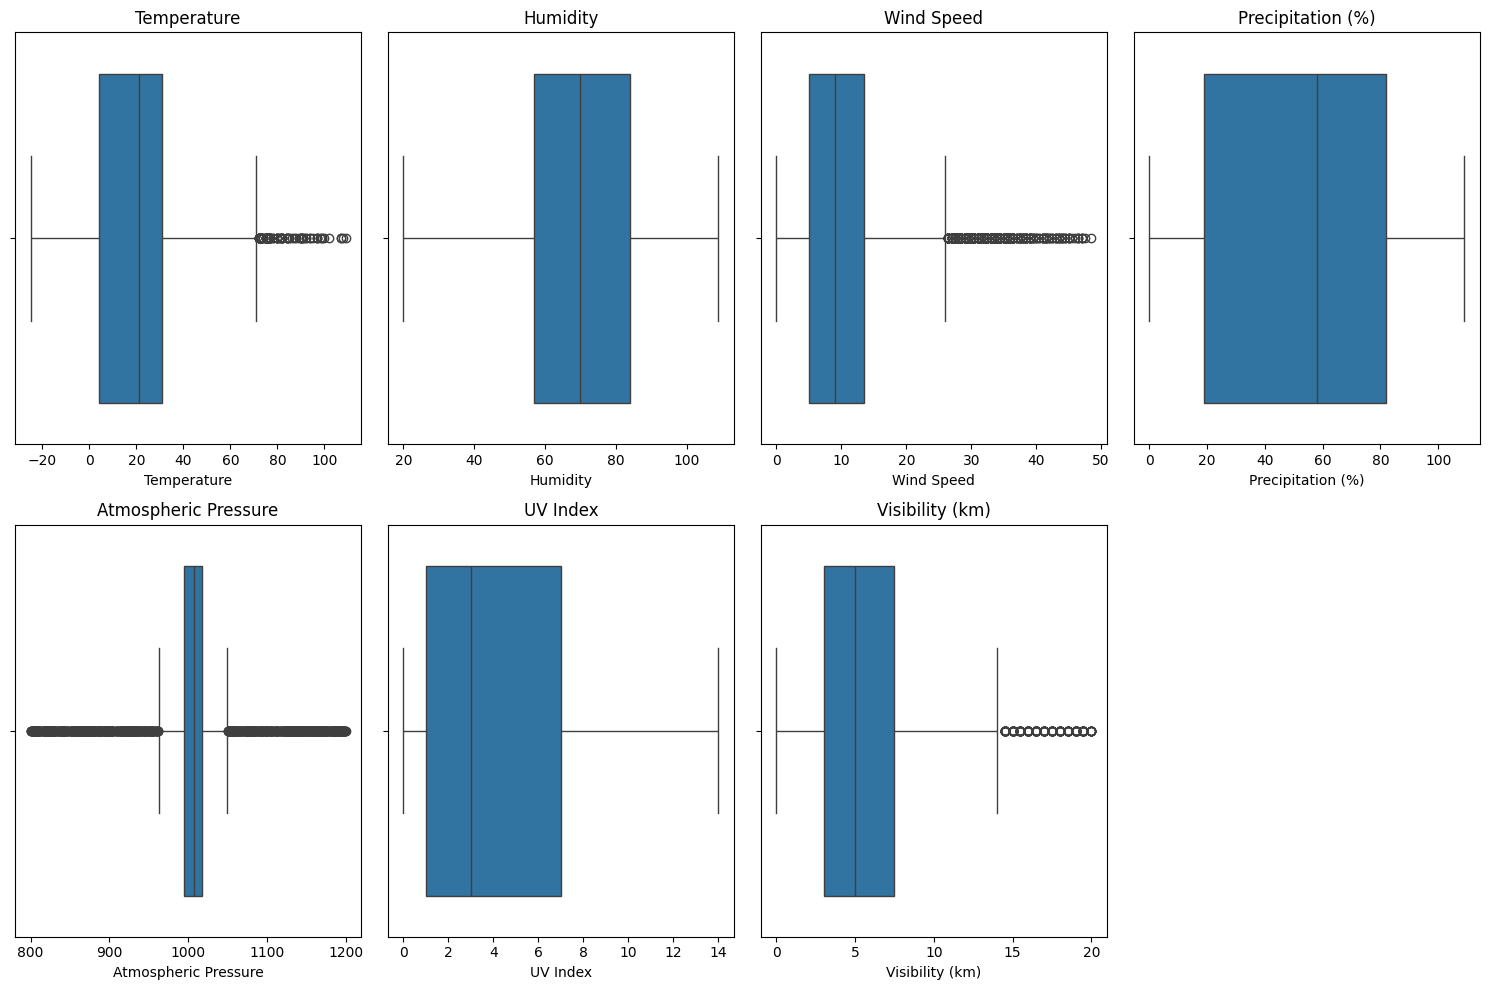

In [9]:
create_boxplots(df)

In [10]:
# Tampilkan
print("Jumlah Outlier pada semua kolom numerikal")
for column in kolom_numerikal:
    outliers = deteksi_outlier(df, column)
    print(f"{column}: {outliers.shape[0]}")

Jumlah Outlier pada semua kolom numerikal
Temperature: 92
Humidity: 0
Wind Speed: 404
Precipitation (%): 0
Atmospheric Pressure: 927
UV Index: 0
Visibility (km): 383


Disini terdeteksi beberapa outlier pada kolom numerikal, kita tidak bisa mengabaikannya karena outlier sangat berdampak signifikan pada perfomansi model yang akan dibuat

**ANALISIS** 🕵

Ada beberapa proses handling outlier yang bisa kita gunakan, yaitu :

- Menghapus Outlier
- Transform data (Ubah Skala Data)
- Cap/Floor (Pembatasan Nilai)
- Imputation (Mengganti Nilai)

Jika dilihat, jumlah dataset yang kita punya itu cukup besar yaitu sebesar 13200 baris data. Oleh karena itu disini saya bisa memutuskan untuk menghapus outlier yang ada pada seluruh kolom, ⚠️⚠️⚠️ **tetapi bukan disini namun saat setelah dilakukan encoding pada fitur target dan lakukan heatmap dikarenakan kita juga harus mengetahui seberapa besar relevansi kolom outlier yang akan kita hapus dengan fitur target** ⚠️⚠️⚠️

# **➥ DATA PREPROCESSING**

## ♢ **ENCODING**

Lakukan encoding pada kolom kategorikal (object)

**Kategori Tipe Ordinal / Nominal**

Sebelum melanjutkan ke tahap encoding, disini kita perlu mengetahui tipe data kategori yang akan kita olah. Oleh karena itu mari kita analisis 

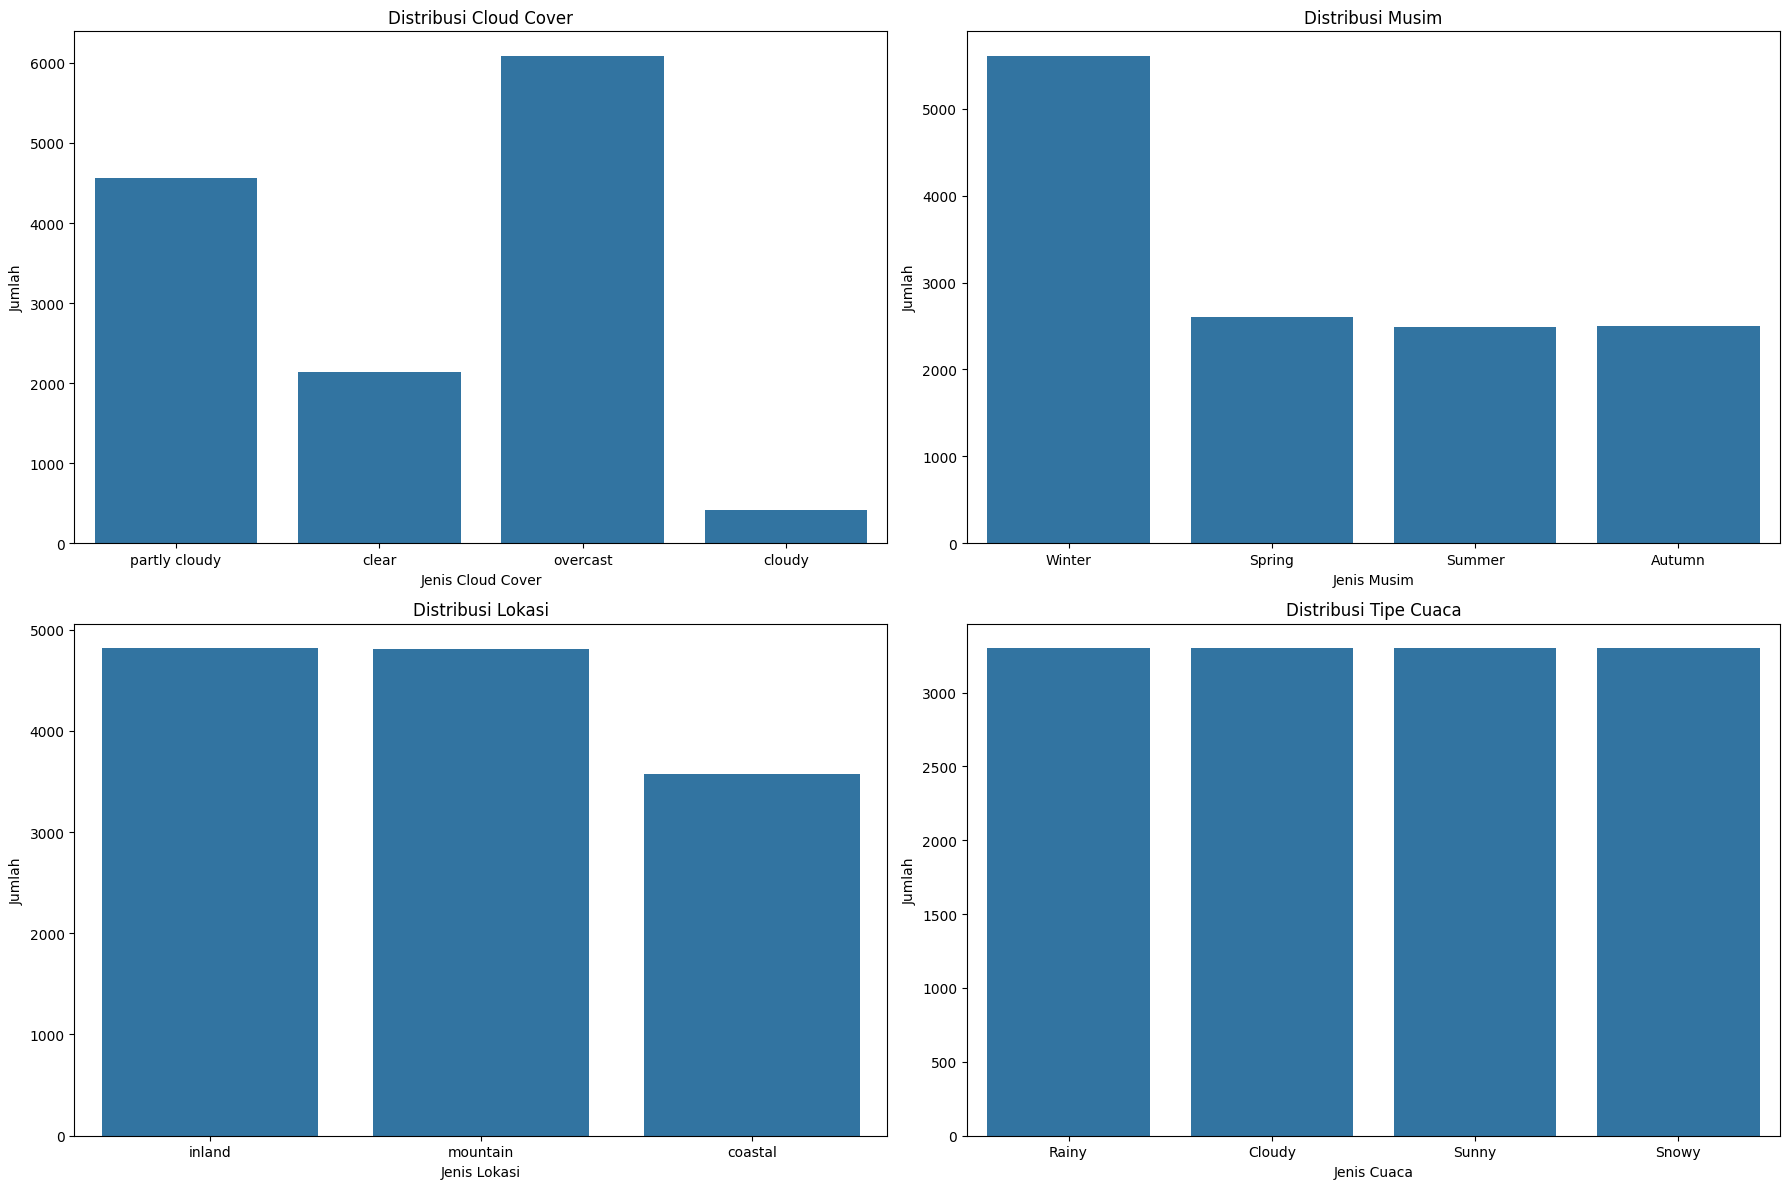

In [11]:
plt.figure(figsize=(18, 12))

plt.subplot(2, 2, 1)
sns.countplot(x='Cloud Cover', data=df)
plt.title('Distribusi Cloud Cover')
plt.xlabel('Jenis Cloud Cover')
plt.ylabel('Jumlah')
plt.xticks(rotation=0)

plt.subplot(2, 2, 2)
sns.countplot(x='Season', data=df)
plt.title('Distribusi Musim')
plt.xlabel('Jenis Musim')
plt.ylabel('Jumlah')
plt.xticks(rotation=0)

plt.subplot(2, 2, 3)
sns.countplot(x='Location', data=df)
plt.title('Distribusi Lokasi')
plt.xlabel('Jenis Lokasi')
plt.ylabel('Jumlah')
plt.xticks(rotation=0)

plt.subplot(2, 2, 4)
sns.countplot(x='Weather Type', data=df)
plt.title('Distribusi Tipe Cuaca')
plt.xlabel('Jenis Cuaca')
plt.ylabel('Jumlah')
plt.xticks(rotation=0)

plt.tight_layout()
plt.show()

**ANALISIS** 🕵

Setelah dianalisis lebih lanjut, maka diperoleh hasil sebagai berikut :

* **Cloud Clover =** Ordinal, dengan urutan **clear -> partly cloudy -> cloudy -> overcast**
* **Season =** Ordinal, dengan urutan mengikuti periode musiman yang terjadi yaitu **Spring -> Summer -> Autumn -> Winter**
* **Weather =** Nominal, tidak ada urutan yang jelas antara masing-masing value yang terkandung di dalamnya
* **Location =** Nominal, tidak ada urutan yang jelas antara masing-masing value yang terkandung di dalamnya

Maka dari itu, berdasarkan hasil analisis diatas kita akan melanjutkan ke tahap encoding berdasarkan hasil yang kita dapatkan

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13200 entries, 0 to 13199
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Temperature           13200 non-null  float64
 1   Humidity              13200 non-null  int64  
 2   Wind Speed            13200 non-null  float64
 3   Precipitation (%)     13200 non-null  float64
 4   Cloud Cover           13200 non-null  object 
 5   Atmospheric Pressure  13200 non-null  float64
 6   UV Index              13200 non-null  int64  
 7   Season                13200 non-null  object 
 8   Visibility (km)       13200 non-null  float64
 9   Location              13200 non-null  object 
 10  Weather Type          13200 non-null  object 
dtypes: float64(5), int64(2), object(4)
memory usage: 1.1+ MB


In [13]:
# Melihat nilai yang telah di-encode
print(df['Location'])

0          inland
1          inland
2        mountain
3         coastal
4        mountain
           ...   
13195    mountain
13196     coastal
13197     coastal
13198      inland
13199    mountain
Name: Location, Length: 13200, dtype: object


In [14]:
# Encoding Label Menggunakan Label Encoder
le = LabelEncoder()
df['Location'] = le.fit_transform(df['Location'])

# Encoding Label Secara Ordinal
df['Cloud Cover'] = df['Cloud Cover'].map({'clear': 0, 'partly cloudy': 1, 'cloudy': 2, 'overcast': 3})
df['Season'] = df['Season'].map({'Spring': 0, 'Summer': 1, 'Autumn': 2, 'Winter': 3})

# Khusus Untuk Target saya lakukan mapping sendiri untuk mengetahui angka target dari dataset saya sendiri
df['Weather Type'] = df['Weather Type'].map({'Sunny': 0, 'Cloudy': 1, 'Rainy': 2, 'Snowy': 3})

In [15]:
# Melihat nilai yang telah di-encode
print(df['Location'])

0        1
1        1
2        2
3        0
4        2
        ..
13195    2
13196    0
13197    0
13198    1
13199    2
Name: Location, Length: 13200, dtype: int64


## ♢ **KORELASI**

Cek Korelasi untuk mengecek relevansi fitur-fitur kolom yang ada dengan target

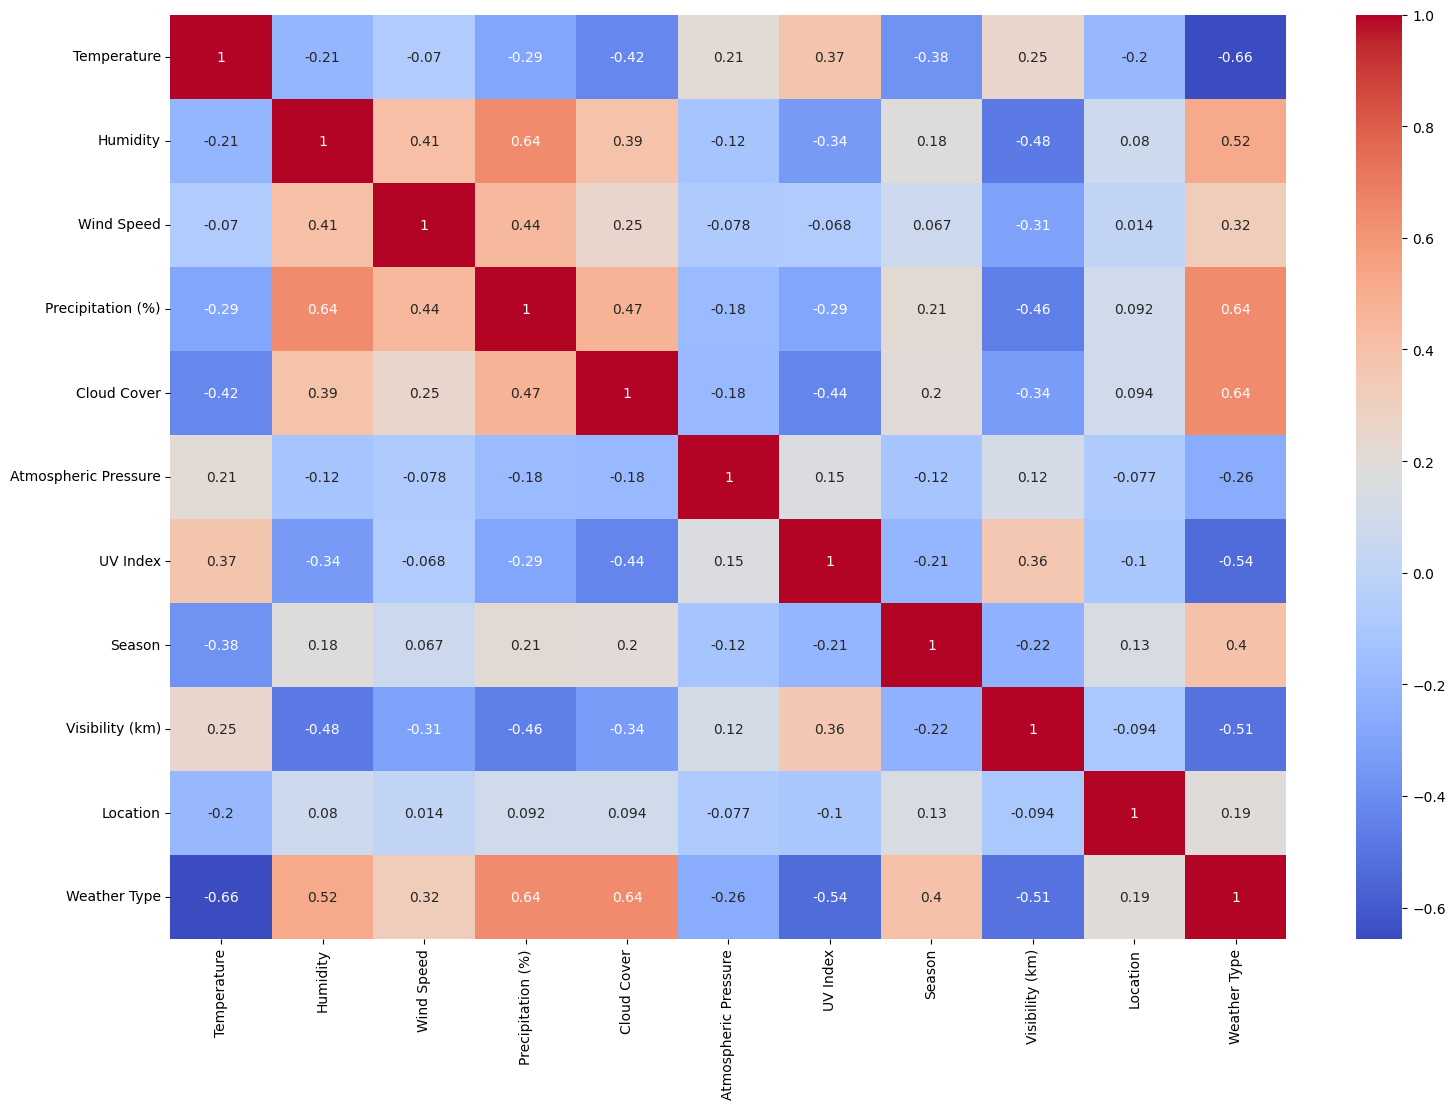

In [16]:
plt.figure(figsize=(18, 12))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.show()

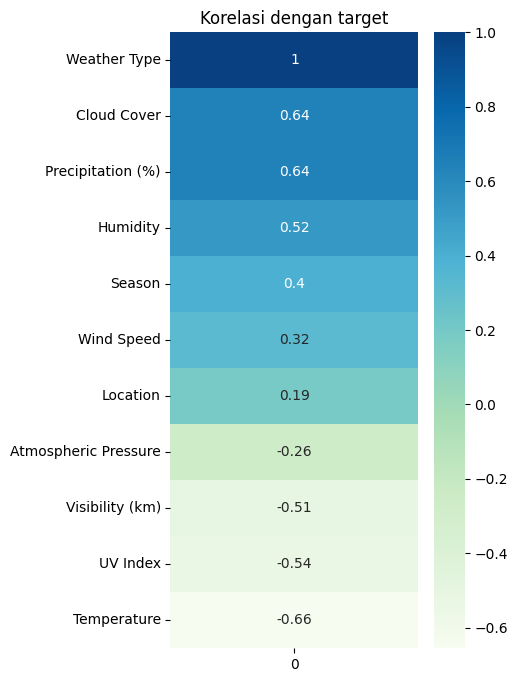

In [17]:
# Buat korelasi matrix target
corr_with_target = df.corrwith(df['Weather Type'])

# Sorting Fitur
corr_with_target = corr_with_target.sort_values(ascending=False)

# Heatmap
plt.figure(figsize=(4, 8))
sns.heatmap(corr_with_target.to_frame(), cmap='GnBu', annot=True)
plt.title('Korelasi dengan target')
plt.show()

## ♢ **HANDLING OUTLIER 2**

Nah setelah dilakukan encoding dan cek korelasi menggunakan heatmap, disini kita bisa menentukan langkah-langkah yang akan kita ambil untuk mengatasi outlier yang ada.

In [18]:
# Tampilkan
print("Jumlah Outlier pada semua kolom numerikal")
for column in kolom_numerikal:
    outliers = deteksi_outlier(df, column)
    print(f"{column}: {outliers.shape[0]}")

Jumlah Outlier pada semua kolom numerikal
Temperature: 92
Humidity: 0
Wind Speed: 404
Precipitation (%): 0
Atmospheric Pressure: 927
UV Index: 0
Visibility (km): 383


Kolom yang mengandung Outlier :

- **Temperature** : 92
- **Wind Speed** : 404
- **Atmospheric Pressure** : 927
- **Visibility (km)** : 383

Berikut langkah yang akan dilakukan berdasarkan semua informasi yang diperoleh :

*  **Temperature** : Hapus, karena memiliki korelasi yang sangat rendah pada target (-0.66)
*  **Wind Speed** : Batasi Outlier, karena relevan dengan target
*  **Atmospheric Pressure** : Hapus, karena memiliki korelasi yang rendah pada target (-0.26)
*  **Visibility (km)** : Hapus, karena memiliki korelasi yang rendah pada target (-0.51)

**1. Kolom Wind Speed**

Pertama-tama pada kolom Wind Speed, setelah di analisis menggunakan visualisasi data. Distribusi data cenderung miring ke kanan oleh karena itu penanganan outlier yang akan dilakukan adalah :

1. Lakukan log Transformation
2. Hapus Outlier yang tersisa

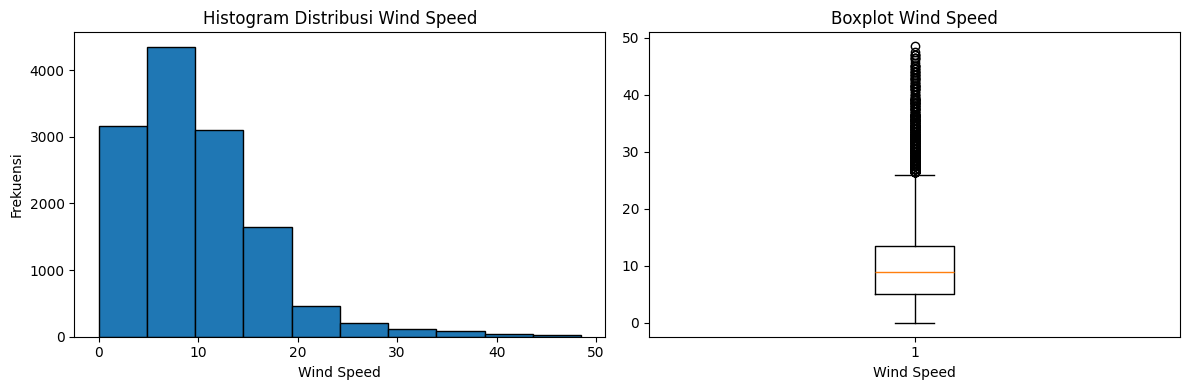

In [19]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(df['Wind Speed'], edgecolor='black')
plt.xlabel('Wind Speed')
plt.ylabel('Frekuensi')
plt.title('Histogram Distribusi Wind Speed')

plt.subplot(1, 2, 2)
plt.boxplot(df['Wind Speed'])
plt.xlabel('Wind Speed')
plt.ylabel('')
plt.title('Boxplot Wind Speed')

plt.tight_layout()
plt.show()

In [20]:
def remove_outliers_kolom(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df

# Log Transformation
df['Wind Speed'] = np.log(df['Wind Speed'] + 1)

# Hapus Outlier
df = remove_outliers_kolom(df, 'Wind Speed')

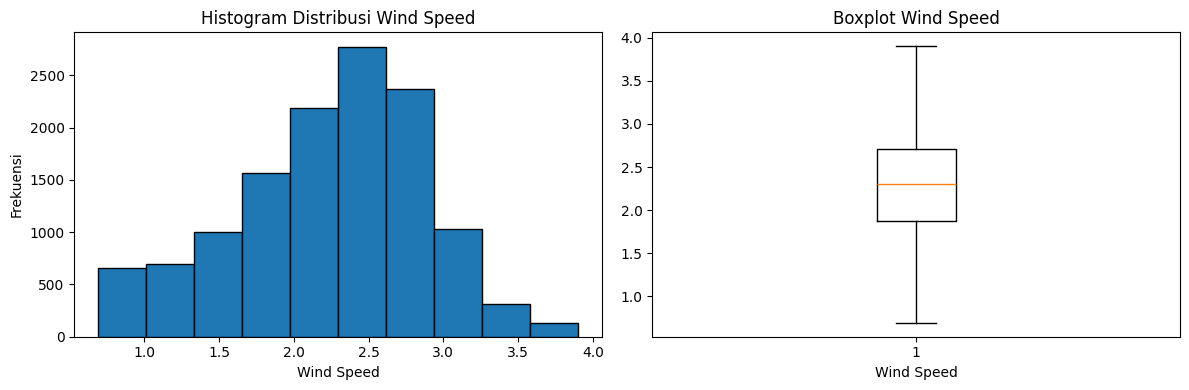

In [21]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(df['Wind Speed'], edgecolor='black')
plt.xlabel('Wind Speed')
plt.ylabel('Frekuensi')
plt.title('Histogram Distribusi Wind Speed')

plt.subplot(1, 2, 2)
plt.boxplot(df['Wind Speed'])
plt.xlabel('Wind Speed')
plt.ylabel('')
plt.title('Boxplot Wind Speed')

plt.tight_layout()
plt.show()

**2. Kolom Temperature, Atmospheric Pressure, dan Visibility (km)**

Untuk kolom yang tersisa kita akan lakukan hapus outlier, mengingat jumlah dataset yang besar

In [22]:
def remove_outliers(df):
    numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns
    for col in numerical_columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df

# Hapus semua outlier
df = remove_outliers(df)

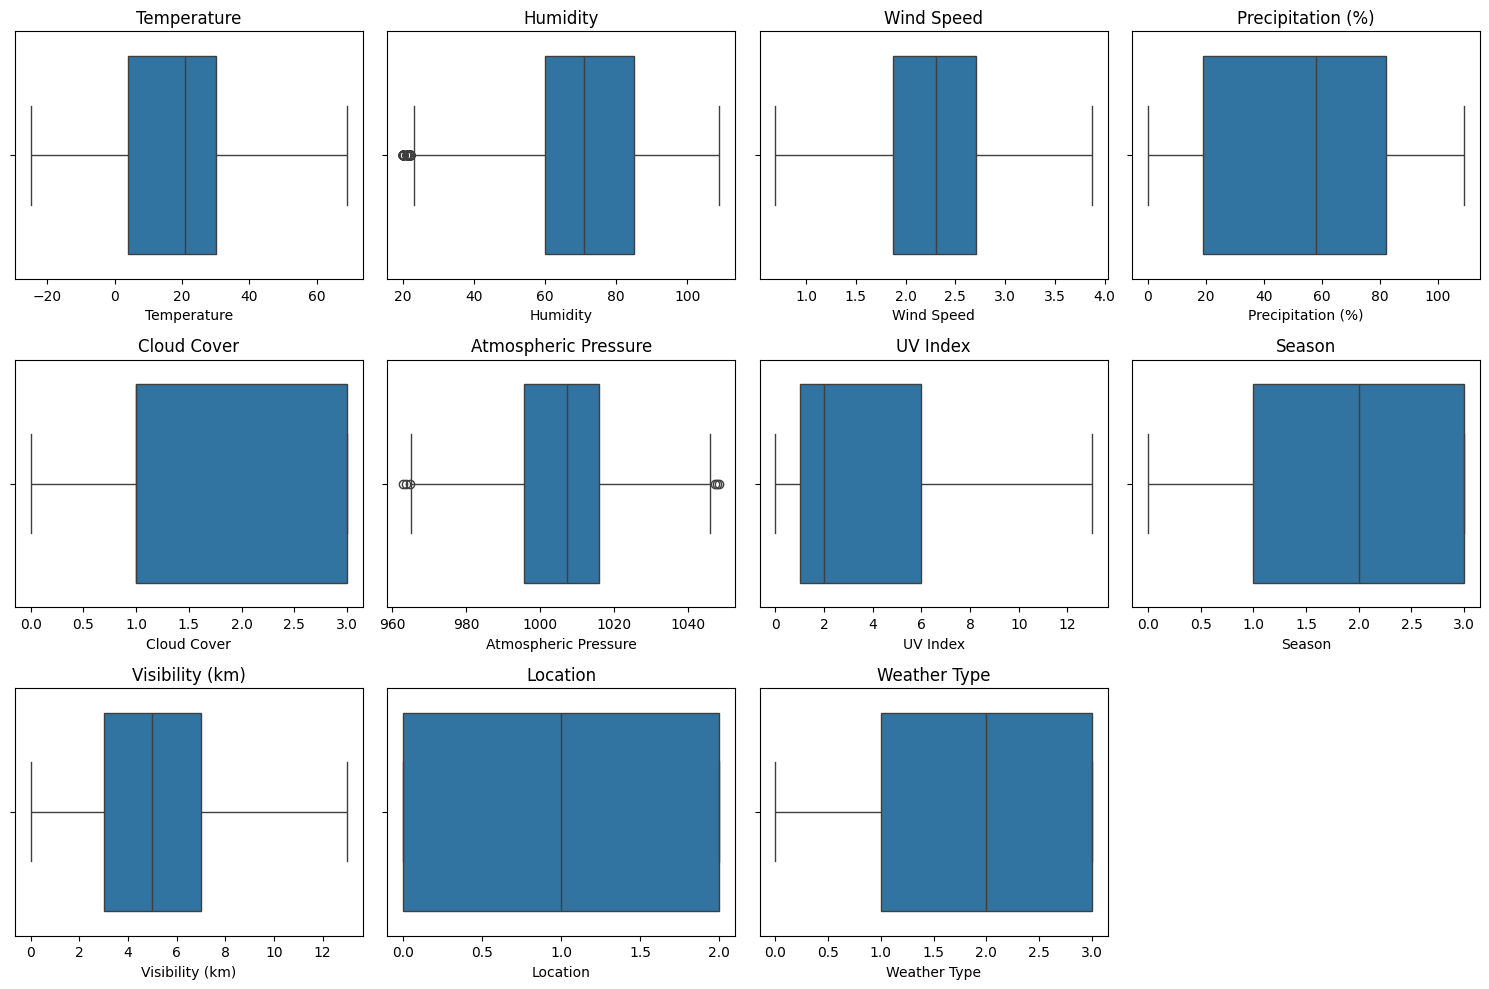

In [23]:
create_boxplots(df)

**ANALISIS** 🕵

Setelah dilakukan penanganan Outlier, outlier yang terdeteksi jadi berkurang. Meskipun disini masih terlihat beberapa outlier, kita akan membiarkan outlier tersebut karena masih berada dekat pada batas yang ada. Oleh karena itu kita bisa lanjut ke tahap selanjutnya

# **➥ MODELLING**

## ♢ **SPLITTING DATA**

In [24]:
# Pisahkan variabel fitur dengan variabel target
X = df.drop(columns = ['Weather Type'], axis=1)
Y = df['Weather Type']

# Pisahkan data menjadi train dan test (Test = 20 %, Train = 80 %)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [25]:
# Ubah ke Numpy Array
X_train = X_train.values
X_test = X_test.values

## ♢ **MODEL YANG AKAN DIGUNAKAN**

List Model yang akan saya gunakan adalah :
* Logistic Regression (menggunakan model lasso)
* Decision Tree
* Random Forest
* Gradient Boosting
* OneVsRestClassifier
* SVC

## ♢ **OPTIMISASI MODEL**

Disini saya akan melakukan optimisasi model dengan menggunakan random search untuk mendapatkan hyperparameter terbaik untuk dimasukkan pada setiap model machine learning yang akan saya gunakan

In [26]:
# Ridge (Modifikasi dari Linear Regression untuk cegah overfitting)
LR = LogisticRegression()
params_LR = {
    'penalty': ['l2'],
    'solver': ['lbfgs', 'saga'],
    'max_iter': [100, 200, 500],
    'multi_class': ['ovr'],
    'random_state': [42]
}

# Decision Tree
DT = DecisionTreeClassifier()
params_DT = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': [2, 5, 7, 9],
    'random_state': [42]
}

# Random Forest
RF = RandomForestClassifier()
params_RF = {
    'n_estimators': [100, 200, 500],
    'max_depth': [None, 2, 5, 7, 9],
    'random_state': [42]
}

# XGB
XGB = xgb.XGBClassifier()
params_XGB = {
    'n_estimators': [100, 200, 500],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [2, 5, 7, 9],
    'reg_alpha': [0, 0.1, 0.2],
    'reg_lambda': [0, 0.1, 0.2],
    'random_state': [42]
}

# OneVsRestClassifier
OVR = OneVsRestClassifier(estimator=RandomForestClassifier())
params_OVR = {
    'estimator__n_estimators': [100, 200, 500],
    'estimator__max_depth': [2, 5, 7, 9],
    'estimator__random_state': [42],
    'n_jobs': [2],
    'verbose': [1]
}

# SVC
svc = SVC()
params_svc = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'degree': [2, 3, 4],
    'probability' : [True]
}

# Random Search untuk mendapatkan best params
random_search_LR = RandomizedSearchCV(estimator=LR, param_distributions=params_LR, n_iter=10, cv=5, scoring='accuracy', random_state=42)
random_search_DT = RandomizedSearchCV(estimator=DT, param_distributions=params_DT, n_iter=10, cv=5, scoring='accuracy', random_state=42)
random_search_RF = RandomizedSearchCV(estimator=RF, param_distributions=params_RF, n_iter=10, cv=5, scoring='accuracy', random_state=42)
random_search_XGB = RandomizedSearchCV(estimator=XGB, param_distributions=params_XGB, n_iter=10, cv=5, scoring='accuracy', random_state=42)
random_search_OVR = RandomizedSearchCV(estimator=OVR, param_distributions=params_OVR, n_iter=10, cv=5, scoring='accuracy', random_state=42)
random_search_svc = RandomizedSearchCV(estimator=svc, param_distributions=params_svc, n_iter=10, cv=5, scoring='accuracy', random_state=42)

## ♢ **TRAIN MODEL**

Disini kita akan melatih model kita berdasarkan hasil RandomSearch yang telah dilakukan

In [27]:
random_search_LR.fit(X_train, Y_train)

c:\Users\Asus\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\Asus\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\Asus\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative 

RandomizedSearchCV(cv=5, estimator=LogisticRegression(),
                   param_distributions={'max_iter': [100, 200, 500],
                                        'multi_class': ['ovr'],
                                        'penalty': ['l2'], 'random_state': [42],
                                        'solver': ['lbfgs', 'saga']},
                   random_state=42, scoring='accuracy')

In [28]:
random_search_DT.fit(X_train, Y_train)

RandomizedSearchCV(cv=5, estimator=DecisionTreeClassifier(),
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [2, 5, 7, 9],
                                        'random_state': [42],
                                        'splitter': ['best', 'random']},
                   random_state=42, scoring='accuracy')

In [29]:
random_search_RF.fit(X_train, Y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(),
                   param_distributions={'max_depth': [None, 2, 5, 7, 9],
                                        'n_estimators': [100, 200, 500],
                                        'random_state': [42]},
                   random_state=42, scoring='accuracy')

In [30]:
random_search_XGB.fit(X_train, Y_train)

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None,
                                           random_state=None, ...),
                   param_distributions={'learning_rate': [0.01, 0.1, 0.2],
                                        'max_depth': [2, 5, 7, 9],
                                        'n_estimators': [100, 200, 500],
                                        'random_state': [42],
                                        'reg_alpha': [0, 0.1, 0.2],
                                        'reg_lambda': [0, 0.1, 0.2]},
                   random_state=42, scoring='accuracy')

In [31]:
random_search_OVR.fit(X_train, Y_train)

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   4 out of   4 | elapsed:    4.4s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   4 out of   4 | elapsed:    2.2s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   4 out of   4 | elapsed:    2.4s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   4 out of   4 | elapsed:    2.2s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   4 out of   4 | elapsed:    2.2s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   4 out of   4 | elapsed:    1.0s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   4 out of   4 | elapsed:   

RandomizedSearchCV(cv=5,
                   estimator=OneVsRestClassifier(estimator=RandomForestClassifier()),
                   param_distributions={'estimator__max_depth': [2, 5, 7, 9],
                                        'estimator__n_estimators': [100, 200,
                                                                    500],
                                        'estimator__random_state': [42],
                                        'n_jobs': [2], 'verbose': [1]},
                   random_state=42, scoring='accuracy')

In [32]:
random_search_svc.fit(X_train, Y_train)

RandomizedSearchCV(cv=5, estimator=SVC(),
                   param_distributions={'C': [0.1, 1, 10], 'degree': [2, 3, 4],
                                        'kernel': ['linear', 'poly', 'rbf',
                                                   'sigmoid'],
                                        'probability': [True]},
                   random_state=42, scoring='accuracy')

## ♢ **EVALUASI MODEL**

Berikut merupakan hasil evaluasi matrix dari semua model diatas

### • **Ridge Regression**

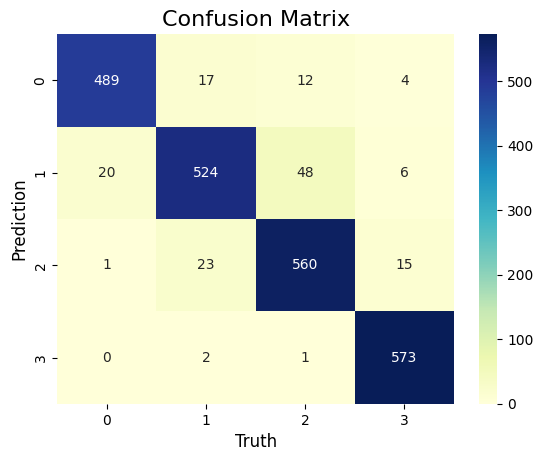

EVALUASI TEST
Accuracy: 0.9350762527233115
Precision: 0.9351686653970976
Recall: 0.9350762527233115
F1: 0.9347518671349214
ROC AUC: 0.9752656203557637

PERBANDINGAN TRAIN DAN TEST


,Train,Test
Matrix,,
Accuracy,0.931583,0.935076
Precision,0.931825,0.935169
Recall,0.931583,0.935076
F1,0.931267,0.934752
ROC AUC,0.972339,0.975266


In [33]:
# Dapatkan Best Parameter
best_params_LR = random_search_LR.best_params_
best_model_LR = random_search_LR.best_estimator_

# Prediksi Model
Y_pred_train = best_model_LR.predict(X_train)
Y_pred_test = best_model_LR.predict(X_test)
Y_pred_train_proba = best_model_LR.predict_proba(X_train)
Y_pred_test_proba = best_model_LR.predict_proba(X_test)

# Confussion Matrix
cm = confusion_matrix(Y_test, Y_pred_test)
sns.heatmap(cm, annot=True,fmt='d', cmap='YlGnBu')
plt.ylabel('Prediction',fontsize=12)
plt.xlabel('Truth',fontsize=12)
plt.title('Confusion Matrix',fontsize=16)
plt.show()

# Evaluasi
print('EVALUASI TEST')
print('Accuracy:', accuracy_score(Y_test, Y_pred_test))
print('Precision:', precision_score(Y_test, Y_pred_test, average='weighted'))
print('Recall:', recall_score(Y_test, Y_pred_test, average='weighted'))
print('F1:', f1_score(Y_test, Y_pred_test, average='weighted'))
print('ROC AUC:', roc_auc_score(Y_test, Y_pred_test_proba, multi_class='ovr'))

# Perbandingan Test dan Train
print('\nPERBANDINGAN TRAIN DAN TEST')
scores_df(Y_test, Y_train, Y_pred_test, Y_pred_train, Y_pred_test_proba, Y_pred_train_proba)

### • **Decision Tree**

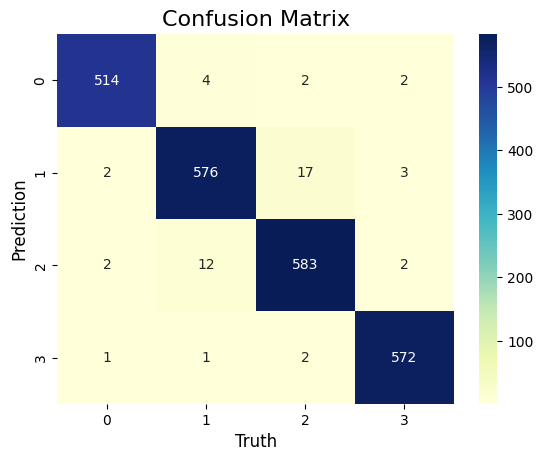

EVALUASI TEST
Accuracy: 0.9782135076252724
Precision: 0.9782300086279223
Recall: 0.9782135076252724
F1: 0.9782094034211474
ROC AUC: 0.9920405087734057

PERBANDINGAN TRAIN DAN TEST


,Train,Test
Matrix,,
Accuracy,0.983549,0.978214
Precision,0.983746,0.978230
Recall,0.983549,0.978214
F1,0.983597,0.978209
ROC AUC,0.999228,0.992041


In [34]:
# Dapatkan Best Parameter
best_params_DT = random_search_DT.best_params_
best_model_DT = random_search_DT.best_estimator_

# Prediksi Model
Y_pred_train = best_model_DT.predict(X_train)
Y_pred_test = best_model_DT.predict(X_test)
Y_pred_train_proba = best_model_DT.predict_proba(X_train)
Y_pred_test_proba = best_model_DT.predict_proba(X_test)

# Confussion Matrix
cm = confusion_matrix(Y_test, Y_pred_test)
sns.heatmap(cm, annot=True,fmt='d', cmap='YlGnBu')
plt.ylabel('Prediction',fontsize=12)
plt.xlabel('Truth',fontsize=12)
plt.title('Confusion Matrix',fontsize=16)
plt.show()

# Evaluasi
print('EVALUASI TEST')
print('Accuracy:', accuracy_score(Y_test, Y_pred_test))
print('Precision:', precision_score(Y_test, Y_pred_test, average='weighted'))
print('Recall:', recall_score(Y_test, Y_pred_test, average='weighted'))
print('F1:', f1_score(Y_test, Y_pred_test, average='weighted'))
print('ROC AUC:', roc_auc_score(Y_test, Y_pred_test_proba, multi_class='ovr'))

# Perbandingan Test dan Train
print('\nPERBANDINGAN TRAIN DAN TEST')
scores_df(Y_test, Y_train, Y_pred_test, Y_pred_train, Y_pred_test_proba, Y_pred_train_proba)

### • **Random Forest**

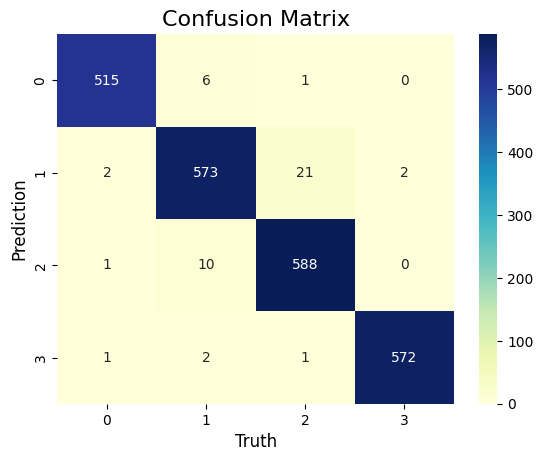

EVALUASI TEST
Accuracy: 0.979520697167756
Precision: 0.9796115165561351
Recall: 0.979520697167756
F1: 0.9795298259479307
ROC AUC: 0.99943551813208

PERBANDINGAN TRAIN DAN TEST


,Train,Test
Matrix,,
Accuracy,1.0,0.979521
Precision,1.0,0.979612
Recall,1.0,0.979521
F1,1.0,0.979530
ROC AUC,1.0,0.999436


In [35]:
# Dapatkan Best Parameter
best_params_RF = random_search_RF.best_params_
best_model_RF = random_search_RF.best_estimator_

# Prediksi Model
Y_pred_train = best_model_RF.predict(X_train)
Y_pred_test = best_model_RF.predict(X_test)
Y_pred_train_proba = best_model_RF.predict_proba(X_train)
Y_pred_test_proba = best_model_RF.predict_proba(X_test)

# Confussion Matrix
cm = confusion_matrix(Y_test, Y_pred_test)
sns.heatmap(cm, annot=True,fmt='d', cmap='YlGnBu')
plt.ylabel('Prediction',fontsize=12)
plt.xlabel('Truth',fontsize=12)
plt.title('Confusion Matrix',fontsize=16)
plt.show()

# Evaluasi
print('EVALUASI TEST')
print('Accuracy:', accuracy_score(Y_test, Y_pred_test))
print('Precision:', precision_score(Y_test, Y_pred_test, average='weighted'))
print('Recall:', recall_score(Y_test, Y_pred_test, average='weighted'))
print('F1:', f1_score(Y_test, Y_pred_test, average='weighted'))
print('ROC AUC:', roc_auc_score(Y_test, Y_pred_test_proba, multi_class='ovr'))

# Perbandingan Test dan Train
print('\nPERBANDINGAN TRAIN DAN TEST')
scores_df(Y_test, Y_train, Y_pred_test, Y_pred_train, Y_pred_test_proba, Y_pred_train_proba)

### • **XGB**

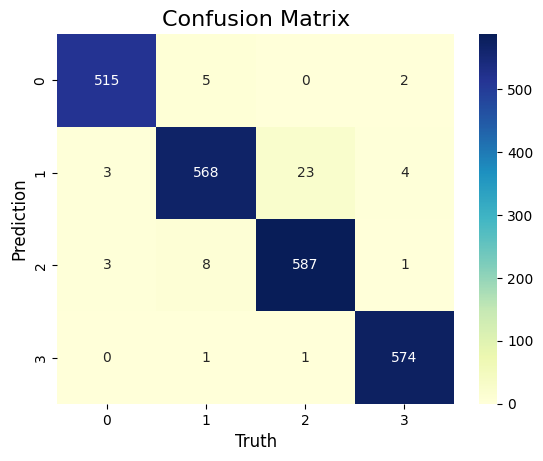

EVALUASI TEST
Accuracy: 0.9777777777777777
Precision: 0.9778366899140721
Recall: 0.9777777777777777
F1: 0.9777313386205784
ROC AUC: 0.999279289888484

PERBANDINGAN TRAIN DAN TEST


,Train,Test
Matrix,,
Accuracy,0.995642,0.977778
Precision,0.995653,0.977837
Recall,0.995642,0.977778
F1,0.995644,0.977731
ROC AUC,0.999949,0.999279


In [36]:
# Dapatkan Best Parameter
best_params_XGB = random_search_XGB.best_params_
best_model_XGB = random_search_XGB.best_estimator_

# Prediksi Model
Y_pred_train = best_model_XGB.predict(X_train)
Y_pred_test = best_model_XGB.predict(X_test)
Y_pred_train_proba = best_model_XGB.predict_proba(X_train)
Y_pred_test_proba = best_model_XGB.predict_proba(X_test)

# Confussion Matrix
cm = confusion_matrix(Y_test, Y_pred_test)
sns.heatmap(cm, annot=True,fmt='d', cmap='YlGnBu')
plt.ylabel('Prediction',fontsize=12)
plt.xlabel('Truth',fontsize=12)
plt.title('Confusion Matrix',fontsize=16)
plt.show()

# Evaluasi
print('EVALUASI TEST')
print('Accuracy:', accuracy_score(Y_test, Y_pred_test))
print('Precision:', precision_score(Y_test, Y_pred_test, average='weighted'))
print('Recall:', recall_score(Y_test, Y_pred_test, average='weighted'))
print('F1:', f1_score(Y_test, Y_pred_test, average='weighted'))
print('ROC AUC:', roc_auc_score(Y_test, Y_pred_test_proba, multi_class='ovr'))

# Perbandingan Test dan Train
print('\nPERBANDINGAN TRAIN DAN TEST')
scores_df(Y_test, Y_train, Y_pred_test, Y_pred_train, Y_pred_test_proba, Y_pred_train_proba)

### • **One vs Rest**

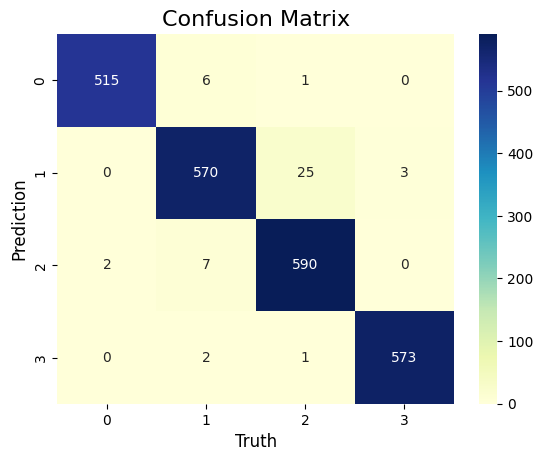

EVALUASI TEST
Accuracy: 0.979520697167756
Precision: 0.9797102425449988
Recall: 0.979520697167756
F1: 0.97952441315653
ROC AUC: 0.9994286215578334

PERBANDINGAN TRAIN DAN TEST


,Train,Test
Matrix,,
Accuracy,0.991829,0.979521
Precision,0.991907,0.979710
Recall,0.991829,0.979521
F1,0.991835,0.979524
ROC AUC,0.999876,0.999429


In [37]:
# Dapatkan Best Parameter
best_params_OVR = random_search_OVR.best_params_
best_model_OVR = random_search_OVR.best_estimator_

# Prediksi Model
Y_pred_train = best_model_OVR.predict(X_train)
Y_pred_test = best_model_OVR.predict(X_test)
Y_pred_train_proba = best_model_OVR.predict_proba(X_train)
Y_pred_test_proba = best_model_OVR.predict_proba(X_test)

# Confussion Matrix
cm = confusion_matrix(Y_test, Y_pred_test)
sns.heatmap(cm, annot=True,fmt='d', cmap='YlGnBu')
plt.ylabel('Prediction',fontsize=12)
plt.xlabel('Truth',fontsize=12)
plt.title('Confusion Matrix',fontsize=16)
plt.show()

# Evaluasi
print('EVALUASI TEST')
print('Accuracy:', accuracy_score(Y_test, Y_pred_test))
print('Precision:', precision_score(Y_test, Y_pred_test, average='weighted'))
print('Recall:', recall_score(Y_test, Y_pred_test, average='weighted'))
print('F1:', f1_score(Y_test, Y_pred_test, average='weighted'))
print('ROC AUC:', roc_auc_score(Y_test, Y_pred_test_proba, multi_class='ovr'))

# Perbandingan Test dan Train
print('\nPERBANDINGAN TRAIN DAN TEST')
scores_df(Y_test, Y_train, Y_pred_test, Y_pred_train, Y_pred_test_proba, Y_pred_train_proba)

### • **SVC**

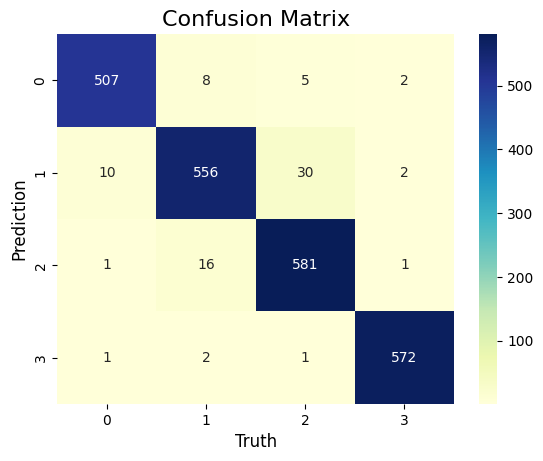

EVALUASI TEST
Accuracy: 0.9655773420479303
Precision: 0.9656970665921326
Recall: 0.9655773420479303
F1: 0.9655353603775347
ROC AUC: 0.9921842548449943

PERBANDINGAN TRAIN DAN TEST


,Train,Test
Matrix,,
Accuracy,0.960453,0.965577
Precision,0.960767,0.965697
Recall,0.960453,0.965577
F1,0.960485,0.965535
ROC AUC,0.990645,0.992184


In [38]:
# Dapatkan Best Parameter
best_params_svc = random_search_svc.best_params_
best_model_svc = random_search_svc.best_estimator_

# Prediksi Model
Y_pred_train = best_model_svc.predict(X_train)
Y_pred_test = best_model_svc.predict(X_test)
Y_pred_train_proba = best_model_svc.predict_proba(X_train)
Y_pred_test_proba = best_model_svc.predict_proba(X_test)

# Confussion Matrix
cm = confusion_matrix(Y_test, Y_pred_test)
sns.heatmap(cm, annot=True,fmt='d', cmap='YlGnBu')
plt.ylabel('Prediction',fontsize=12)
plt.xlabel('Truth',fontsize=12)
plt.title('Confusion Matrix',fontsize=16)
plt.show()

# Evaluasi
print('EVALUASI TEST')
print('Accuracy:', accuracy_score(Y_test, Y_pred_test))
print('Precision:', precision_score(Y_test, Y_pred_test, average='weighted'))
print('Recall:', recall_score(Y_test, Y_pred_test, average='weighted'))
print('F1:', f1_score(Y_test, Y_pred_test, average='weighted'))
print('ROC AUC:', roc_auc_score(Y_test, Y_pred_test_proba, multi_class='ovr'))

# Perbandingan Test dan Train
print('\nPERBANDINGAN TRAIN DAN TEST')
scores_df(Y_test, Y_train, Y_pred_test, Y_pred_train, Y_pred_test_proba, Y_pred_train_proba)

## ♢ **EVALUASI AKHIR**

Berdasarkan semua hasil model yang telah dilakukan, maka setelah dilakukan semua percobaan dan analisis. Disini saya akhirnya memutuskan untuk menggunakan model dengan nilai terbaik yaitu ada pada

* Random Forest

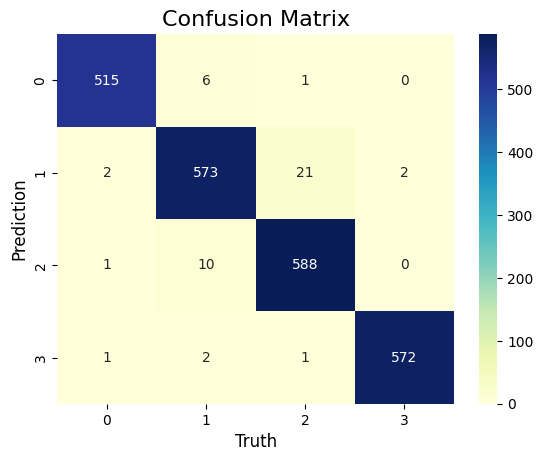

Param yang digunakan :
{'random_state': 42, 'n_estimators': 500, 'max_depth': None}
EVALUASI TEST
Accuracy: 0.979520697167756
Precision: 0.9796115165561351
Recall: 0.979520697167756
F1: 0.9795298259479307
ROC AUC: 0.99943551813208

PERBANDINGAN TRAIN DAN TEST


,Train,Test
Matrix,,
Accuracy,1.0,0.979521
Precision,1.0,0.979612
Recall,1.0,0.979521
F1,1.0,0.979530
ROC AUC,1.0,0.999436


In [39]:
# Dapatkan Best Parameter
best_params_RF = random_search_RF.best_params_
best_model_RF = random_search_RF.best_estimator_

# Prediksi Model
Y_pred_train = best_model_RF.predict(X_train)
Y_pred_test = best_model_RF.predict(X_test)
Y_pred_train_proba = best_model_RF.predict_proba(X_train)
Y_pred_test_proba = best_model_RF.predict_proba(X_test)

# Confussion Matrix
cm = confusion_matrix(Y_test, Y_pred_test)
sns.heatmap(cm, annot=True,fmt='d', cmap='YlGnBu')
plt.ylabel('Prediction',fontsize=12)
plt.xlabel('Truth',fontsize=12)
plt.title('Confusion Matrix',fontsize=16)
plt.show()

print('Param yang digunakan :')
print(best_params_RF)

# Evaluasi
print('EVALUASI TEST')
print('Accuracy:', accuracy_score(Y_test, Y_pred_test))
print('Precision:', precision_score(Y_test, Y_pred_test, average='weighted'))
print('Recall:', recall_score(Y_test, Y_pred_test, average='weighted'))
print('F1:', f1_score(Y_test, Y_pred_test, average='weighted'))
print('ROC AUC:', roc_auc_score(Y_test, Y_pred_test_proba, multi_class='ovr'))

# Perbandingan Test dan Train
print('\nPERBANDINGAN TRAIN DAN TEST')
scores_df(Y_test, Y_train, Y_pred_test, Y_pred_train, Y_pred_test_proba, Y_pred_train_proba)

# **➥ PIPELINE**

Disini kita akan membuat sebuah pipeline berdasarkan hasil evaluasi model kita

In [40]:
from sklearn.pipeline import make_pipeline

pipeline = make_pipeline(best_model_RF)

In [41]:
import pickle

with open("weather.pkl", "wb") as model_file:
    pickle.dump(best_model_RF, model_file)

In [42]:
df.head()

,Temperature,Humidity,Wind Speed,Precipitation (%),Cloud Cover,Atmospheric Pressure,UV Index,Season,Visibility (km),Location,Weather Type
0,14.0,73,2.351375,82.0,1,1010.82,2,3,3.5,1,2
1,39.0,96,2.251292,71.0,1,1011.43,7,0,10.0,1,1
2,30.0,64,2.079442,16.0,0,1018.72,5,0,5.5,2,0
3,38.0,83,0.916291,82.0,0,1026.25,7,0,1.0,0,0
4,27.0,74,2.890372,66.0,3,990.67,1,3,2.5,2,2


In [43]:
# Inference Data
new_data = [14.0, 73, 2.351375, 82.0, 1, 1010.82, 2, 3, 3.5, 1]

best_model_RF.predict([new_data])

array([2])

In [44]:
import pickle

with open("weather.pkl", "rb") as model_file:
    model = pickle.load(model_file)

In [45]:
df.head()

,Temperature,Humidity,Wind Speed,Precipitation (%),Cloud Cover,Atmospheric Pressure,UV Index,Season,Visibility (km),Location,Weather Type
0,14.0,73,2.351375,82.0,1,1010.82,2,3,3.5,1,2
1,39.0,96,2.251292,71.0,1,1011.43,7,0,10.0,1,1
2,30.0,64,2.079442,16.0,0,1018.72,5,0,5.5,2,0
3,38.0,83,0.916291,82.0,0,1026.25,7,0,1.0,0,0
4,27.0,74,2.890372,66.0,3,990.67,1,3,2.5,2,2


In [46]:
df.describe()

,Temperature,Humidity,Wind Speed,Precipitation (%),Cloud Cover,Atmospheric Pressure,UV Index,Season,Visibility (km),Location,Weather Type
count,11474.000000,11474.000000,11474.000000,11474.000000,11474.000000,11474.000000,11474.000000,11474.000000,11474.000000,11474.000000,11474.000000
mean,18.872146,70.358986,2.239652,53.504183,1.800505,1005.917734,3.555081,1.882081,4.979998,1.106676,1.529719
std,15.957243,19.363196,0.635973,32.079621,1.206997,12.868148,3.510213,1.169406,2.586466,0.786746,1.109705
min,-25.000000,20.000000,0.693147,0.000000,0.000000,962.880000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.000000,60.000000,1.871802,19.000000,1.000000,995.590000,1.000000,1.000000,3.000000,0.000000,1.000000
50%,21.000000,71.000000,2.302585,58.000000,1.000000,1007.320000,2.000000,2.000000,5.000000,1.000000,2.000000
75%,30.000000,85.000000,2.708050,82.000000,3.000000,1016.000000,6.000000,3.000000,7.000000,2.000000,3.000000
max,69.000000,109.000000,3.871201,109.000000,3.000000,1048.570000,13.000000,3.000000,13.000000,2.000000,3.000000


In [47]:
# Assuming you have a DataFrame named 'df'
df.to_csv('Dataset_Final/weather_modified.csv', index=False)

In [48]:
# Inference Data
new_data = [14.0, 73, 2.351375, 82.0, 1, 1010.82, 2, 3, 3.5, 1]

model.predict([new_data])

array([2])